# Homework 2

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Madison Rusch, Thomas McDonnell, Benjamin Panovich, Elie Kostenbaum

In [319]:
import pandas as pd
import numpy as np
import datetime
import math
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../cmds')
from binomial import *

# 1. Stripping Caps

The file `data/cap_curves_2023-03-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [320]:
filepath = '../data/cap_curves_2023-03-31.xlsx'
data = pd.read_excel(filepath)

def black_derman_toy(discount_factor, T, strike, underlying, sigma):
    d_1 = (math.log(underlying/strike) + (sigma**2 * T / 2)) / (sigma * math.sqrt(T))
    d_2 = d_1 - (sigma * math.sqrt(T))
    value = discount_factor * (underlying * norm.cdf(d_1) - strike * norm.cdf(d_2))
    return value

def black_derman_toy_get_forward_vol(sigma, price, discount_factor, T, strike, underlying):
    return black_derman_toy(discount_factor, T, strike, underlying, sigma) - price

selected_caps = data.loc[data["tenor"] <= 10]
display(selected_caps.head())

,tenor,swap rates,discounts,forwards,flat vols
0,0.25,0.049149,0.987862,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491
2,0.75,0.048306,0.964628,0.046724,0.303075
3,1.00,0.047170,0.954188,0.043764,0.369483
4,1.25,0.045246,0.945312,0.037559,0.420688


In [321]:
selected_caps["cap price"] = np.zeros(len(selected_caps))
for tenor in selected_caps["tenor"].values[1:]:
    flat_vol = selected_caps.loc[selected_caps["tenor"] == tenor]["flat vols"]
    sum_of_caplets = 0
    for caplet in np.arange(0.5, tenor+.01, 0.25):
        discount_factor = selected_caps.loc[selected_caps["tenor"] == caplet]["discounts"]
        strike = selected_caps.loc[selected_caps["tenor"] == caplet]["swap rates"]
        forward = selected_caps.loc[selected_caps["tenor"] == caplet]["forwards"]
        caplet_price = black_derman_toy(discount_factor, caplet - 0.25, strike, forward, flat_vol)
        sum_of_caplets = sum_of_caplets + caplet_price.values[0]
    cap_price = (100 / 4) * sum_of_caplets
    selected_caps.loc[selected_caps["tenor"] == tenor, "cap price"] = cap_price

display(selected_caps.head())

,tenor,swap rates,discounts,forwards,flat vols,cap price
0,0.25,0.049149,0.987862,NaN,NaN,0.000000
1,0.50,0.049097,0.975896,0.049045,0.219491,0.051758
2,0.75,0.048306,0.964628,0.046724,0.303075,0.151557
3,1.00,0.047170,0.954188,0.043764,0.369483,0.289431
4,1.25,0.045246,0.945312,0.037559,0.420688,0.423923


Text(0.5, 1.0, 'The price of caps from 0.5 to 10')

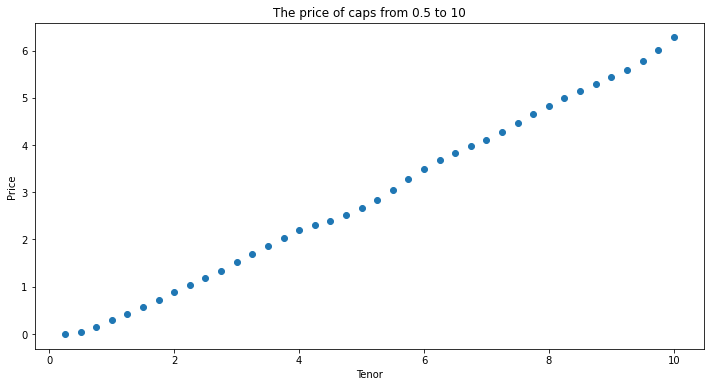

In [322]:
plt.scatter(x=selected_caps["tenor"], y=selected_caps["cap price"])
plt.xlabel("Tenor")
plt.ylabel("Price")
plt.title("The price of caps from 0.5 to 10")

## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [323]:
selected_caps["forward vols"] = np.zeros(len(selected_caps))
for tenor in selected_caps["tenor"].values[1:]:
    cap_price = selected_caps.loc[selected_caps["tenor"] == tenor, "cap price"]
    previous_caplet_prices = selected_caps.loc[selected_caps["tenor"] < tenor].iloc[-1]["cap price"]
    caplet_price = (cap_price - previous_caplet_prices) * (4/100)
    discount_factor = selected_caps.loc[selected_caps["tenor"] == tenor]["discounts"]
    strike = selected_caps.loc[selected_caps["tenor"] == tenor]["swap rates"]
    forward = selected_caps.loc[selected_caps["tenor"] == tenor]["forwards"]
    forward_vol = fsolve(black_derman_toy_get_forward_vol, .5, args=(caplet_price, discount_factor, tenor-0.25, strike, forward))
    selected_caps.loc[selected_caps["tenor"] == tenor, "forward vols"] = forward_vol
    
display(selected_caps.head())

,tenor,swap rates,discounts,forwards,flat vols,cap price,forward vols
0,0.25,0.049149,0.987862,NaN,NaN,0.000000,0.000000
1,0.50,0.049097,0.975896,0.049045,0.219491,0.051758,0.219491
2,0.75,0.048306,0.964628,0.046724,0.303075,0.151557,0.365756
3,1.00,0.047170,0.954188,0.043764,0.369483,0.289431,0.471866
4,1.25,0.045246,0.945312,0.037559,0.420688,0.423923,0.554569


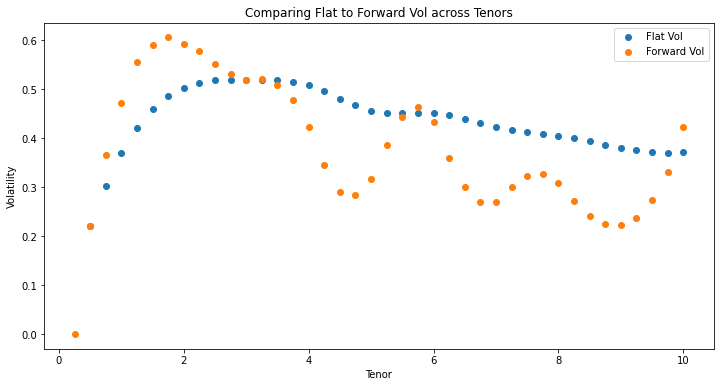

In [324]:
plt.scatter(x=selected_caps["tenor"], y=selected_caps["flat vols"], label="Flat Vol")
plt.scatter(x=selected_caps["tenor"], y=selected_caps["forward vols"], label="Forward Vol")
plt.xlabel("Tenor")
plt.ylabel("Volatility")
plt.legend()
plt.title("Comparing Flat to Forward Vol across Tenors")
plt.show()

***

# 2. Pricing a Callable Bond with BDT

## 2.1 Calibrate a BDT model 

Use data from the file `data/cap_curves_2023-03-31.xlsx` to calibrate the model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
    * If you could not solve 1.2, then use $\sigma=.35$ at every step.
    * You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.
    
* Given these $\sigma$ parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

Display the series of $\theta$ parameters.

Display the tree of rates from $0\le t \le 10$.

In [325]:
selected_caps.iloc[0]["forward vols"] = selected_caps.iloc[1]["forward vols"]
selected_caps["bond prices"] = selected_caps["discounts"] * 100

selected_caps = selected_caps.set_index("tenor")
quotes = pd.DataFrame(index=selected_caps.index, data=selected_caps["bond prices"])
vols = pd.DataFrame(index=selected_caps.index, data=selected_caps["forward vols"])
quotes.T
vols.T

tenor,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,...,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
forward vols,0.219491,0.219491,0.365756,0.471866,0.554569,0.590991,0.605537,0.59204,0.578438,0.551026,...,0.32742,0.308907,0.27177,0.24097,0.223859,0.221985,0.237344,0.272609,0.331745,0.421678


In [326]:
ratetree = construct_rate_tree(dt=.25, T=10)
format_bintree(ratetree, style='{:.2%}')

theta = pd.Series(dtype=float, index=ratetree.columns)
dt = ratetree.columns[1] - ratetree.columns[0]

for tsteps, t in enumerate(ratetree.columns[:-1]):
    if tsteps==0:
        ratetree.iloc[0,0] = -np.log(quotes.iloc[tsteps]/100)/dt
    else:
        subtree = ratetree.iloc[:tsteps+1,:tsteps+1]
        wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, vols.iloc[tsteps].values[0]).loc[0,0] - quotes.iloc[tsteps]
        theta.iloc[tsteps-1] = fsolve(wrapper,.5)[0]

        ratetree.loc[:,t] = incrementBDTtree(subtree, theta.iloc[tsteps-1], vols.iloc[tsteps].values[0]).loc[:,t]

#### Theta series

In [327]:
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
0,-3.22%,-39.85%,-58.81%,-102.60%,-72.54%,-74.92%,-32.83%,-71.62%,-8.41%,-8.74%,-3.12%,-19.93%,-6.83%,18.64%,18.79%,18.65%,47.71%,72.39%,54.94%,22.95%,9.01%,7.47%,16.58%,33.75%,44.65%,48.46%,45.23%,36.21%,30.07%,28.10%,30.56%,36.34%,39.45%,39.42%,36.38%,30.06%,20.03%,5.55%,-14.75%,,


#### Tree of Rates

In [328]:
format_bintree(ratetree,style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75,10.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.88%,5.41%,5.88%,6.42%,6.56%,7.35%,8.25%,10.22%,11.41%,14.72%,18.77%,24.15%,29.79%,37.78%,50.28%,65.13%,81.06%,105.57%,145.74%,195.79%,251.43%,320.94%,412.18%,533.46%,695.02%,903.00%,1165.93%,1494.17%,1900.30%,2407.97%,3042.68%,3832.76%,4808.15%,5986.01%,7388.36%,9041.74%,10975.64%,13224.26%,15828.27%,18835.89%,
1,,4.34%,4.72%,5.16%,5.27%,5.90%,6.63%,8.21%,9.16%,11.82%,15.07%,19.39%,23.92%,30.33%,40.37%,52.30%,65.09%,84.77%,117.02%,157.21%,201.88%,257.69%,330.95%,428.33%,558.05%,725.04%,936.15%,1199.71%,1525.80%,1933.43%,2443.05%,3077.43%,3860.59%,4806.33%,5932.32%,7259.86%,8812.64%,10618.12%,12708.95%,15123.85%,
2,,,3.27%,3.58%,3.65%,4.09%,4.60%,5.69%,6.36%,8.20%,10.45%,13.45%,16.59%,21.04%,28.01%,36.28%,45.15%,58.80%,81.17%,109.05%,140.04%,178.75%,229.57%,297.12%,387.10%,502.94%,649.38%,832.20%,1058.40%,1341.16%,1694.67%,2134.73%,2677.98%,3334.01%,4115.08%,5035.96%,6113.08%,7365.49%,8815.84%,10490.99%,
3,,,,2.23%,2.28%,2.55%,2.87%,3.55%,3.96%,5.11%,6.52%,8.39%,10.35%,13.13%,17.47%,22.63%,28.17%,36.68%,50.64%,68.03%,87.36%,111.51%,143.21%,185.35%,241.49%,313.75%,405.11%,519.16%,660.27%,836.67%,1057.20%,1331.72%,1670.63%,2079.88%,2567.14%,3141.62%,3813.57%,4594.87%,5499.65%,6544.67%,
4,,,,,1.31%,1.47%,1.65%,2.04%,2.28%,2.94%,3.75%,4.82%,5.94%,7.54%,10.03%,13.00%,16.18%,21.07%,29.08%,39.07%,50.17%,64.04%,82.25%,106.45%,138.69%,180.19%,232.66%,298.16%,379.21%,480.51%,607.17%,764.83%,959.47%,1194.52%,1474.36%,1804.29%,2190.21%,2638.92%,3158.55%,3758.73%,
5,,,,,,0.81%,0.91%,1.13%,1.26%,1.63%,2.07%,2.67%,3.29%,4.17%,5.56%,7.20%,8.96%,11.67%,16.11%,21.64%,27.78%,35.47%,45.55%,58.95%,76.80%,99.79%,128.84%,165.12%,210.00%,266.10%,336.24%,423.55%,531.34%,661.50%,816.47%,999.18%,1212.89%,1461.38%,1749.14%,2081.50%,
6,,,,,,,0.50%,0.62%,0.69%,0.89%,1.13%,1.46%,1.80%,2.28%,3.03%,3.93%,4.89%,6.37%,8.79%,11.81%,15.16%,19.36%,24.86%,32.17%,41.92%,54.46%,70.32%,90.12%,114.61%,145.23%,183.51%,231.16%,289.99%,361.03%,445.61%,545.33%,661.97%,797.59%,954.65%,1136.05%,
7,,,,,,,,0.34%,0.38%,0.49%,0.63%,0.81%,0.99%,1.26%,1.68%,2.17%,2.70%,3.52%,4.86%,6.53%,8.39%,10.71%,13.75%,17.80%,23.19%,30.13%,38.90%,49.85%,63.40%,80.34%,101.52%,127.88%,160.42%,199.72%,246.51%,301.68%,366.20%,441.23%,528.11%,628.46%,
8,,,,,,,,,0.21%,0.28%,0.35%,0.45%,0.56%,0.71%,0.94%,1.22%,1.52%,1.98%,2.73%,3.66%,4.70%,6.00%,7.71%,9.98%,13.00%,16.90%,21.81%,27.96%,35.55%,45.05%,56.93%,71.71%,89.96%,112.00%,138.24%,169.17%,205.36%,247.43%,296.15%,352.42%,


## 2.2 Price the Freddie Mac Bond

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `BX8543742`.
* Issued 2022-07-26
* Matures 2030-07-26
* Semiannual coupons
* Coupon rate 4.375%
* Issued 25mm.

Price this bond using the model calibrated from 2023-03-31 data.
* We will model this bond as maturing 2030-06-30 (a few weeks early) so that it has maturity of 7.25 years, modeled at quarterly intervals.
* Note that the coupons are paid in the final period and every other quarter prior (semiannually.) Thus, it pays a coupon in after just one quarter from the current time.

The market quote as of 2023-03-31 is \$97.478.

Use the BDT model to price the bond. How close is it to the market quote?

In [329]:
def bintree_pricing_with_T(payoff=None, ratetree=None, undertree=None,cftree=None, pstars=None,timing=None,style='european', time_to_maturity=None):
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if undertree.columns.to_series().diff().std()>1e-8:
        display('time grid is unevenly spaced')
    dt = undertree.columns[1]-undertree.columns[0]

    
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t], time_to_maturity-t)
            if timing== 'deferred':
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back] + cftree.loc[state,t])

            if style=='american':
                valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t], time_to_maturity-t) + np.exp(-ratetree.loc[:,t]*dt) * cftree.loc[:,t])

    return valuetree


def bond_price(face_value, maturity_in_years, ytm, coupon, frequency=2):
    freq = float(frequency)
    periods = maturity_in_years*freq
    numerator = coupon*face_value/freq
    dt = [(i+1)/freq for i in range(int(periods))]
    price = sum([numerator/(1+ytm/freq)**(freq*t) for t in dt]) + \
            face_value/(1+ytm/freq)**(freq*maturity_in_years)
    return price


compound = 2
T = 7.25
dt = 0.25
payoff = lambda r, T : bond_price(100, T, r, 0.04375)

tsteps = int(T/dt) + 1
refratetree = compound * (np.exp(ratetree / compound)-1)

cftree = refratetree.copy()
cftree.loc[:,cftree.columns.values % 0.5 == 0] = 4.375
cftree.loc[:,cftree.columns.values % 0.5 != 0] = 0

format_bintree(refratetree.iloc[:tsteps,:tsteps], style='{:.2%}')
underlying = bintree_pricing_with_T(payoff=payoff, time_to_maturity=T, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree, undertree=refratetree.iloc[:tsteps,:tsteps]).style.format('{:.2f}',na_rep='').format_index('{:.2f}',axis=1)
underlying


time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,137.10,129.10,124.94,115.84,110.44,99.91,93.11,81.45,73.87,61.71,54.09,42.66,36.21,26.36,21.76,14.28,11.99,6.70,6.14,2.72,3.25,1.01,1.75,0.27,0.79,0.04,0.24,0.04,0.90,100.00
1,,139.72,136.78,129.00,124.99,115.87,110.41,99.91,93.24,81.56,73.95,61.97,54.42,42.90,36.19,26.32,21.61,13.91,11.31,6.19,5.63,2.44,2.77,0.77,1.27,0.19,0.52,0.24,2.30,100.00
2,,,145.71,139.07,136.35,128.67,124.77,115.85,110.73,100.48,94.06,82.87,75.67,63.90,56.37,45.00,38.37,28.21,23.07,15.36,12.72,7.48,6.52,3.15,3.20,1.33,1.85,1.71,7.40,100.00
3,,,,146.00,144.28,137.78,135.23,127.81,124.30,115.77,111.06,101.48,95.73,85.10,78.34,67.15,60.18,48.96,42.28,32.42,27.63,19.88,16.86,11.25,10.02,6.77,7.49,8.26,20.03,100.00
4,,,,,149.35,143.68,142.10,135.83,133.61,126.55,123.45,115.55,111.53,102.63,97.54,87.76,81.94,71.43,65.04,54.79,49.24,40.11,35.68,28.23,25.73,21.15,22.18,24.25,40.45,100.00
5,,,,,,147.25,146.31,140.80,139.45,133.44,131.52,124.93,122.36,115.03,111.63,103.53,99.38,90.47,85.55,76.36,71.59,62.77,58.48,50.68,47.95,42.88,44.18,46.36,61.74,100.00
6,,,,,,,148.79,143.74,142.94,137.59,136.44,130.73,129.17,122.97,120.84,114.10,111.43,104.05,100.74,93.02,89.61,81.95,78.71,71.63,69.51,64.57,65.87,66.83,78.37,100.00
7,,,,,,,,145.45,144.98,140.03,139.35,134.18,133.25,127.78,126.49,120.68,119.03,112.79,110.71,104.19,101.99,95.45,93.32,87.13,85.75,81.06,82.11,81.47,89.08,100.00
8,,,,,,,,,146.18,141.46,141.06,136.21,135.66,130.63,129.87,124.63,123.64,118.13,116.87,111.18,109.82,104.10,102.77,97.28,96.44,91.93,92.69,90.76,95.50,100.00


Using the BDT Model, we found that the price of the bond was $137.10. This isn't great considering the market quote is $97.48, it seems really high.

## 2.3 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Furthermore, this bond is callable with **American** style--it can be called any quarter.
* Strike is 100.
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

**Use the BDT model to price this implicit American call option and the resulting callable bond.**
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now? 

#### Caution on coupons
* Be careful in modeling the underlying for the American option.
* In pricing the bond in the previous problem, you should have considered the coupon values.
* But in pricing the option, you must account for the fact that the price drops by the coupon value at the node the coupon is paid. (That is, the tree shows the *ex-coupon* price.)
* Consider building the bond valuation tree for the problem above which incorporates the coupons, similar to the cashflow trees we used in W.2. for caps and swaps.
* But then adjust this bond value tree by subtracting the current period's coupons in order to build the underlying tree.

In [330]:
def bintree_pricing_with_T_callable_option(payoff=None, ratetree=None, undertree=None,cftree=None, pstars=None,timing=None,style='european', time_to_maturity=None, coupon=0):
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if undertree.columns.to_series().diff().std()>1e-8:
        display('time grid is unevenly spaced')
    dt = undertree.columns[1]-undertree.columns[0]

    
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        subtract_coupon = 0
        if (t % 0.5 == 0):
            subtract_coupon = coupon
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t], time_to_maturity-t) - subtract_coupon
            if timing== 'deferred':
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back] + cftree.loc[state,t])

            if style=='american':
                # display(valuetree)
                # print(subtract_coupon)
                valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t], time_to_maturity-t) - subtract_coupon)

    return valuetree

compound = 2
T = 7.25
dt = 0.25
strike = 100
payoff = lambda r, T: np.maximum(bond_price(100, T, r, 0.04375) - strike, 0)

tsteps = int(T/dt) + 1
refratetree = compound * (np.exp(ratetree / compound)-1)
format_bintree(refratetree.iloc[:tsteps,:tsteps], style='{:.2%}')
american_option = bintree_pricing_with_T_callable_option(payoff=payoff, time_to_maturity=T, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree=refratetree.iloc[:tsteps,:tsteps], style='american', coupon = 4.375).style.format('{:.2f}',na_rep='').format_index('{:.2f}',axis=1)
american_option

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10.01,8.17,6.42,4.82,3.42,2.28,1.43,0.82,0.43,0.20,0.09,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,12.10,10.15,8.22,6.36,4.67,3.23,2.09,1.25,0.68,0.34,0.15,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,14.32,12.32,10.29,8.22,6.26,4.47,3.02,1.88,1.06,0.54,0.26,0.11,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,16.55,14.57,12.55,10.36,8.19,6.05,4.26,2.78,1.62,0.87,0.42,0.19,0.07,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,18.72,16.75,14.90,12.68,10.47,7.95,5.86,4.03,2.45,1.36,0.69,0.32,0.13,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,,,,,,20.81,18.72,17.24,15.01,13.11,10.16,7.79,5.72,3.61,2.09,1.08,0.54,0.24,0.08,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,,,,,,,21.10,20.29,18.05,17.01,14.15,12.64,9.96,7.92,5.21,3.15,1.67,0.86,0.40,0.15,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,,,,,,,,21.96,19.73,19.16,16.57,15.74,13.23,12.10,9.02,7.34,4.69,2.52,1.35,0.66,0.28,0.08,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,,,,,,,,,20.66,20.34,17.91,17.45,15.06,14.44,11.69,10.77,8.19,6.93,3.74,2.07,1.08,0.48,0.15,0.03,0.00,0.00,0.00,0.00,0.00,0.00


If we find that price of the call is $10.01, and the bond on it's own was worth $137.10, then we would expect this callable bond to be worth $127.09. This is still pretty off.

## 2.4 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised any time it is in-the-money? What stands out about this relationship?

In [331]:
american_option = american_option.data

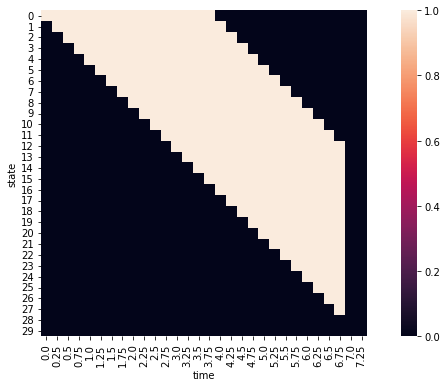

In [332]:
sns.heatmap(american_option > 0,square=True);

As expected, we only exercise the option in the lower part of the tree, where the interest rate goes down and the price of the bond goes up.

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?